# Equity models

In [1]:
import sys, os, ipynbname
NOTEBOOK_NAME = f"{ipynbname.name()}.ipynb"
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(NOTEBOOK_NAME), os.path.pardir)))

In [2]:
# Main functions
from src.Constants import *
from src.Utils import *

# Model simulation
from src.EquityModel import *
from src.BlackScholes import *
from src.Heston import *

from src.RatesModel import *
from src.Vasicek import *
from src.CIR import *
from src.HullWhite import *

## Preliminary

### Generation of 2 correlated Brownian Motions

**Remark**: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.

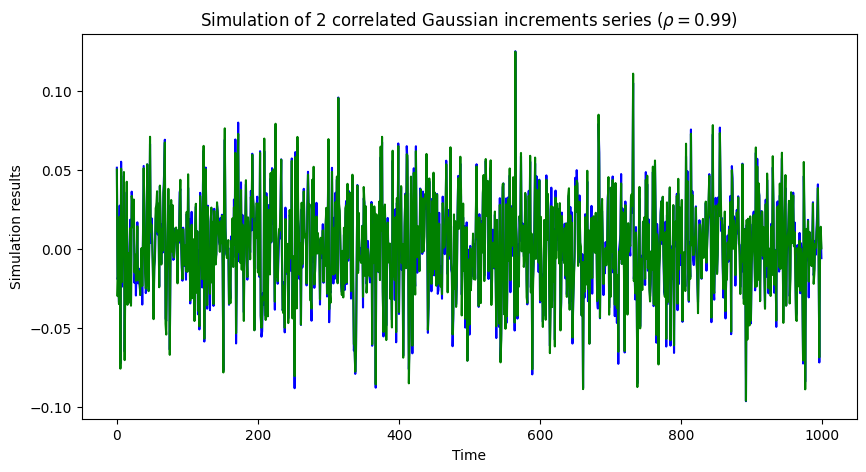

In [3]:
# Generation of Gaussian increments (Gaussian sequences)
rho_ = 0.99
for path in Utils.generate_correlated_gaussians(rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Gaussian increments series ($\rho =${rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

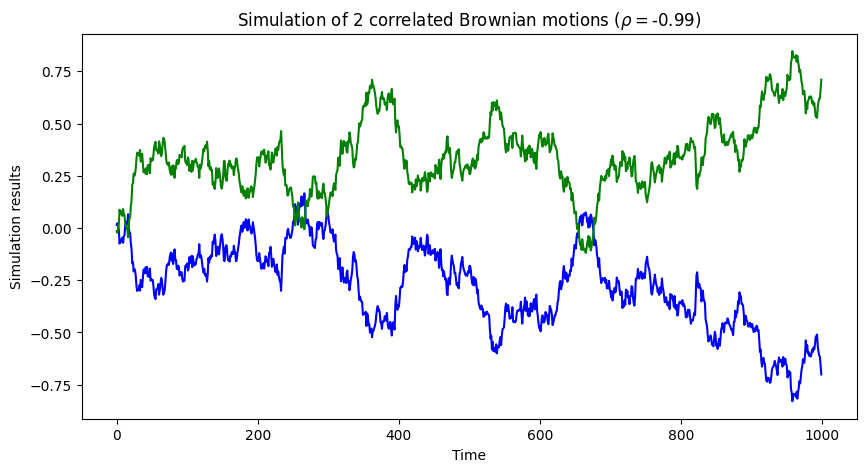

In [5]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in Utils.generate_correlated_brownians(-rho_, N=int(1e3)):
    plt.plot(path)
_ = plt.title(rf"Simulation of 2 correlated Brownian motions ($\rho =${-rho_})")
_ = plt.xlabel("Time")
_ = plt.ylabel("Simulation results")

### Generation of $k > 2$ correlated Brownian Motions

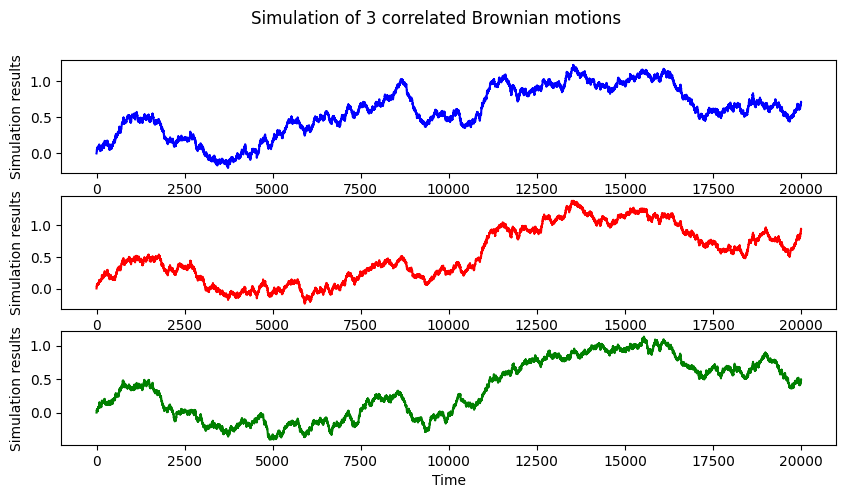

In [6]:
# Declaration of a correlation matrix
Sigma = np.array([
    [1, 0.8, 0.6],
    [0.8, 1, 0.7],
    [0.6, 0.7, 1]
])

colors = ["blue", "red", "green"]
sim_ = Utils.generate_correlated_brownians(Sigma)
for i, path in enumerate(sim_):
    plt.subplot(len(sim_), 1, i + 1)
    _ = plt.plot(path, color=colors[i])
    _ = plt.ylabel("Simulation results")
_ = plt.suptitle(rf"Simulation of 3 correlated Brownian motions")
_ = plt.xlabel("Time")

## Black & Scholes

In [15]:
S0 = 1
sigma = 0.7
rho = 0.5
r = CIR(0.4, 0.20, 0.01, 0.12) # Vasicek(0.01875, 0.20, 0.01, 0.014)
model = BlackScholes(S0, r, sigma, rho)

In [16]:
d = model.simulate_euler(T=4.2, getRates=True)
df = pd.DataFrame(d)
df.head()

,t,S,r
0,0.00000,1.000000,0.400000
1,0.00021,1.006433,0.399733
2,0.00042,0.997257,0.399240
3,0.00063,0.996351,0.399529
4,0.00084,1.002737,0.399764


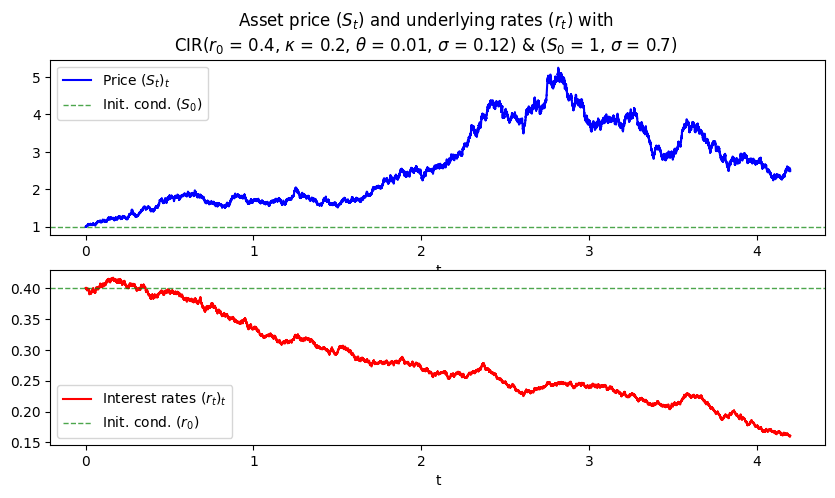

In [17]:
# Plotting the asset price and the interest rates evolution over time 
_, axes = plt.subplots(nrows=2, ncols=1)
_ = df.plot(x = "t", y = "S", color="blue", label="Price $(S_t)_t$", ax=axes[0])
_ = axes[0].axhline(y = model.S0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(S_0)$")
_ = df.plot(x = "t", y = "r", color="red", label="Interest rates $(r_t)_t$", ax=axes[1])
_ = axes[1].axhline(y = r.r0, color="green", ls="--", lw=1, alpha=0.7, label="Init. cond. $(r_0)$")
axes[0].legend()
axes[1].legend()
_ = plt.suptitle(f"Asset price $(S_t)$ and underlying rates $(r_t)$ with\n{r.MODEL_NAME}{r.get_parameter_string()} & {model.get_parameter_string()}")

## Heston

In [20]:
# TODO